# Personalised Mecidine - Exploratory Data Analysis

## Goal of project
Automatically classify genetic mutations that contribute to cancer tumor growth drivers) vs. presence of mutations that don’t affect the tumors (passengers)

## Importing data

In [40]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [41]:
var_path = "Data/training_variants"
text_path = "Data/training_text"

d_train = pd.read_csv(var_path)
d_text = pd.read_csv(text_path, sep = "\|\|", skiprows=1, names = ['ID','Text'], engine="python")

## Variants file

### Variable Understanding

In [42]:
d_train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
dtype: object

- ID - A specific gene of the specimen
- Gene - The specific gene where the mutation took place
- Variation - the nature of the mutation
- Class - Class which we must predict
    - between 1 and 9

In [43]:
d_train.apply(pd.Series.nunique)

ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64

We now know that there are 3321 records in our training set - all of which are unique.
Although we have 264 unique genes and 2996 unique variations.
Lastly there are 9 classes.

In [44]:
d_train.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

We know that there are no null values in the dataset.

### Univariant Analysis

### Class

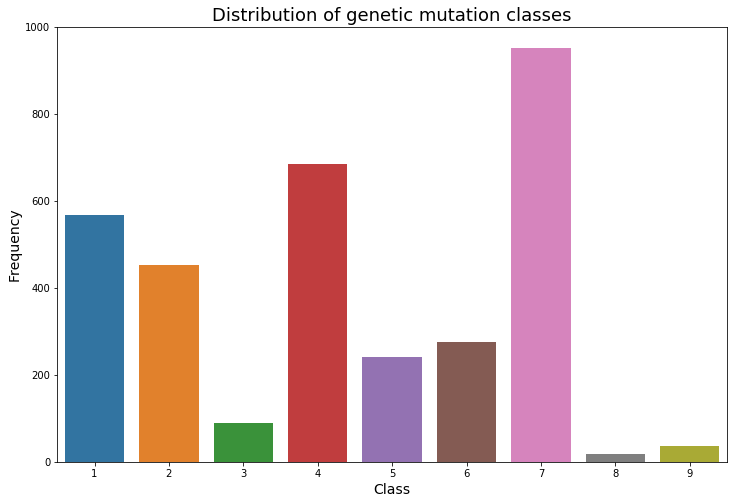

In [45]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

- Class 7 is very common, followed by 1, 2, and 4
- Class 3, 8, 9 are not very common

### Gene

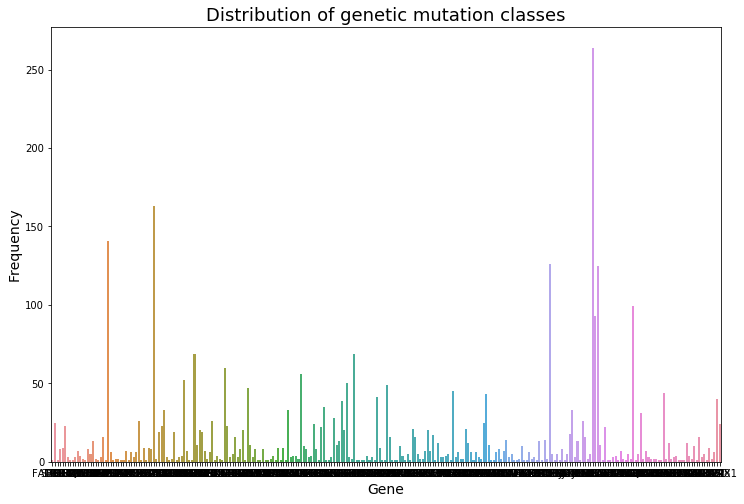

In [46]:
plt.figure(figsize=(12,8))
sns.countplot(x="Gene", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Gene', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

In [47]:
# Find top 10 genes
gene_freq = d_train['Gene'].value_counts()
print("Top-10 Gene Occurances\n")
print(gene_freq.head(10))

Top-10 Gene Occurances

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64


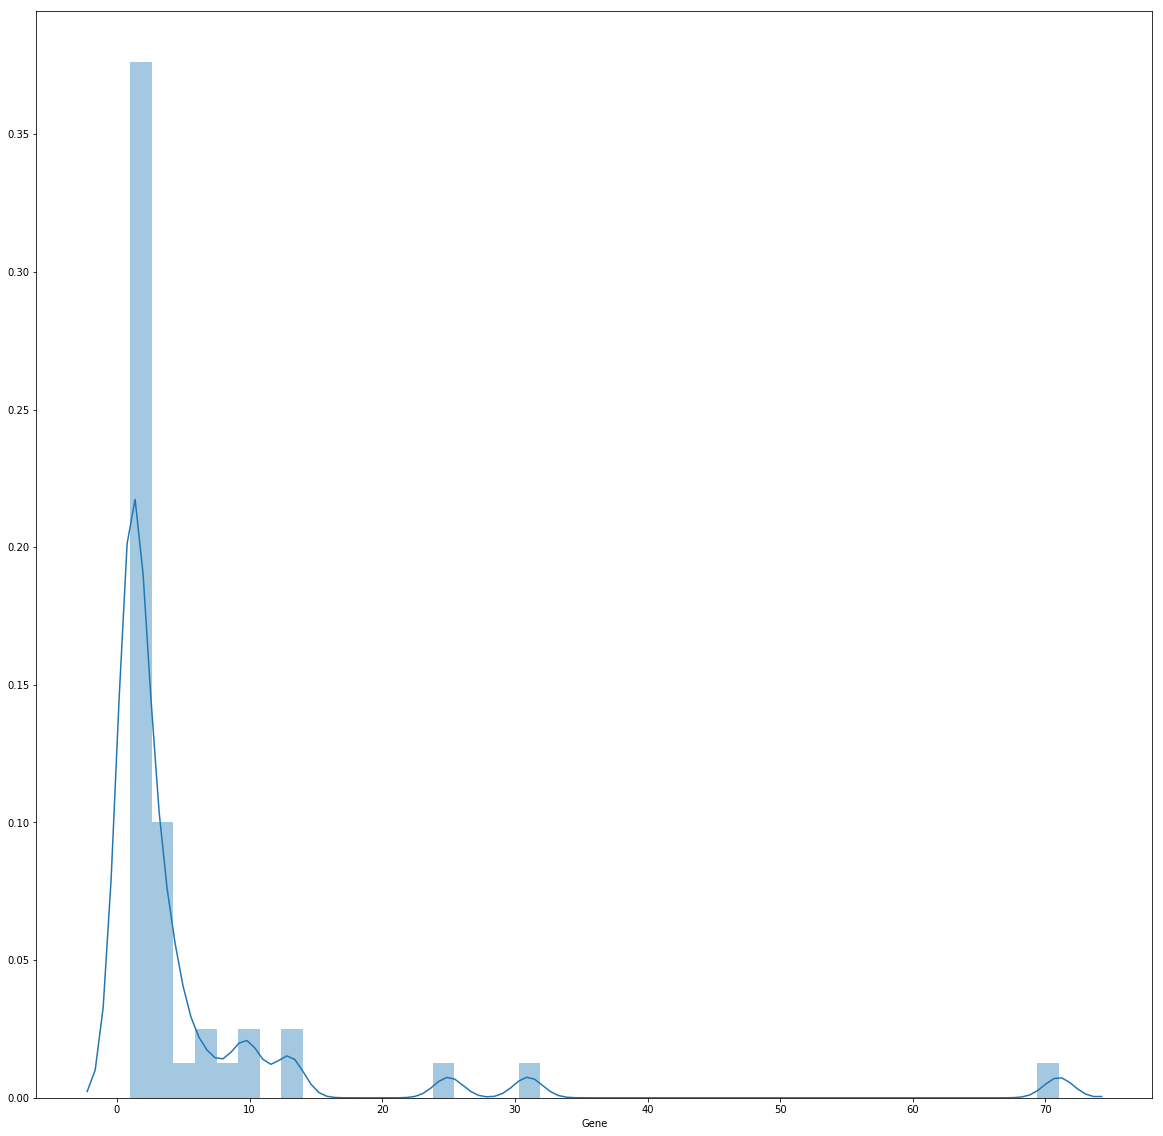

In [48]:
#Look at distribution of frequency of genes
plt.figure(figsize=(20,20))
sns.distplot(gene_freq.value_counts())

- There are a lot of genes that appear only once, and quite a few appear twice

In [49]:
#Get frequency and standard deviation for genes occuring more than once
filter_genes = gene_freq[gene_freq > 2]
print(stats.kurtosis(filter_genes),stats.skew(filter_genes))

24.253454297558463 4.360256036389982


### Variation

In [50]:
print("Description of Variation")
print(d_train['Variation'].describe())
print("\nTop Five Variations")
print(d_train['Variation'].value_counts().head(5))

Description of Variation
count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

Top Five Variations
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Variation, dtype: int64


- There are a lot of unique variation
- Only the top foud variations appear somewhat often
- Variation may not provide much information

## Bivariant Analysis

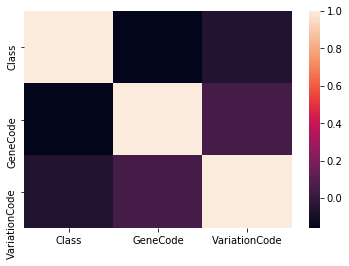

In [51]:
# Converting Gene and Variation to categories
d_train['Gene'] = d_train['Gene'].astype('category')
d_train['Variation'] = d_train['Variation'].astype('category')
d_train['Gene'].head().cat.codes
d_train['GeneCode'] = d_train['Gene'].cat.codes
d_train['VariationCode'] = d_train['Variation'].cat.codes
d_train.head()

# Calculate correlations
corr = d_train[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.figure(figsize=(10,10))
plt.show()

- There does not appear to be much correlation anywhere

### Gene and Variation

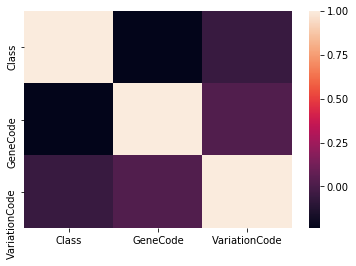

In [52]:
#Correlation using top 20 genes
top_20_genes = d_train[(d_train['Gene'].isin(gene_freq.head(20).index))]

# Calculate correlations
corr = top_20_genes[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.show()

- Slightly better, but still does not appear to have much correlation

### Top 20 Gene Distribution by Class

In [53]:
#top_20_genes.head()
#g = sns.factorplot("Gene", hue="Gene", col="Class", data=top_20_genes, kind="count")

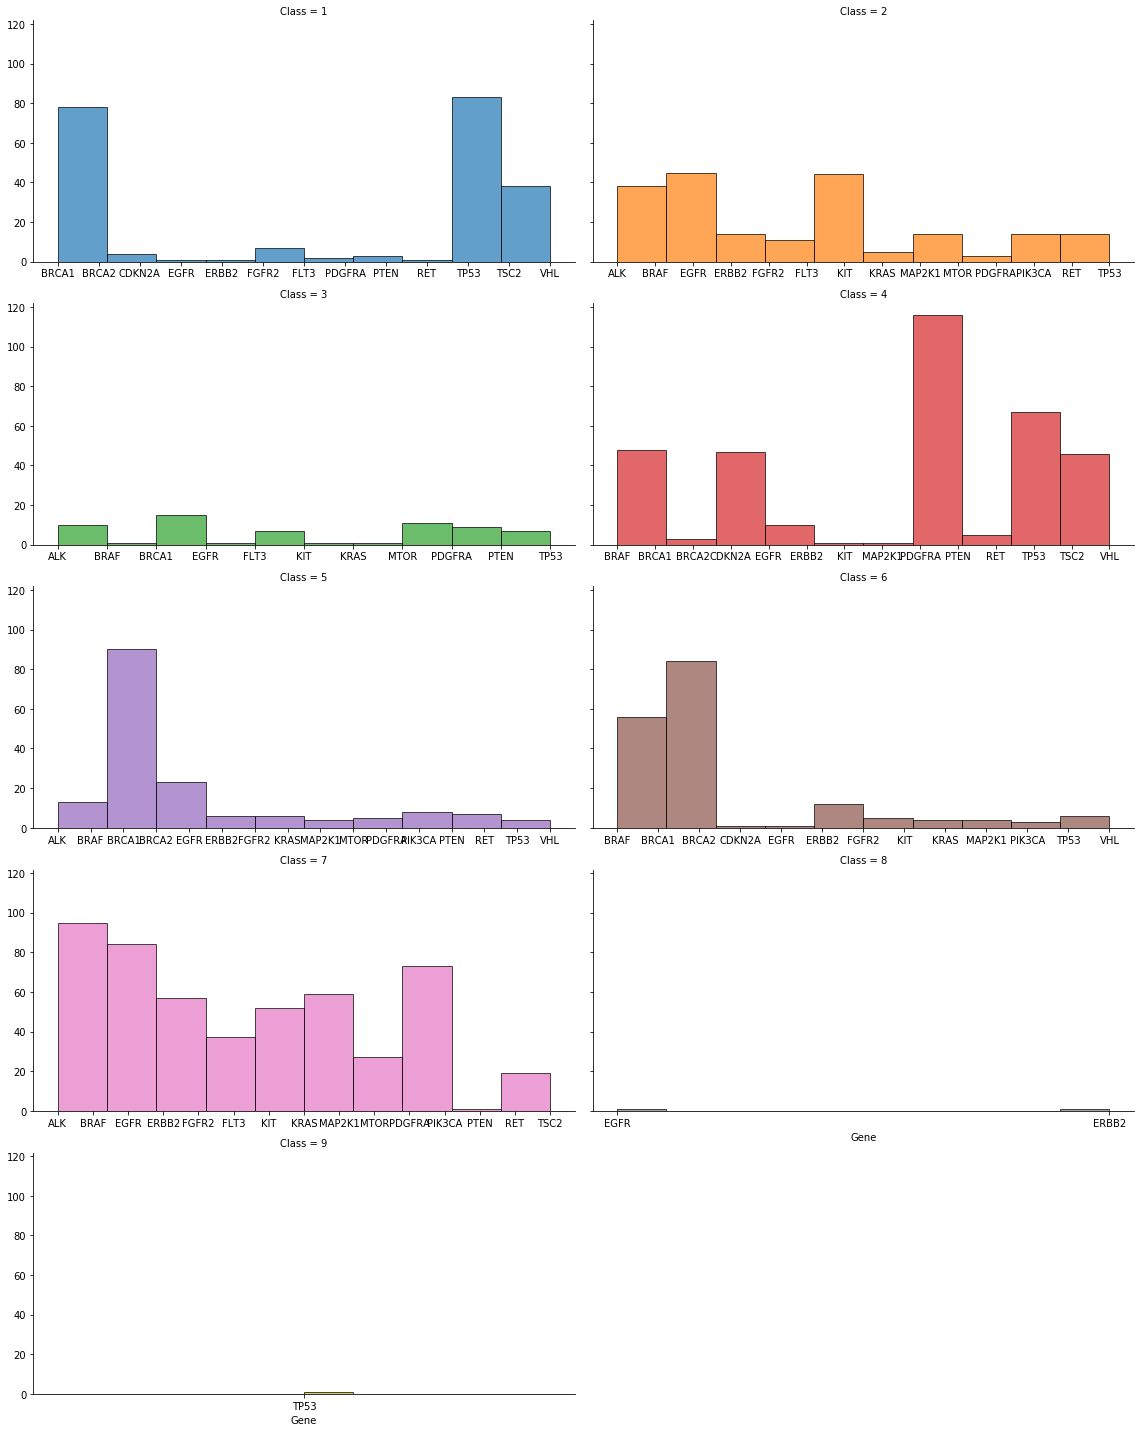

In [54]:
g = sns.FacetGrid(top_20_genes, col="Class", col_wrap=2, size=4, aspect=2, hue="Class", margin_titles=True, sharex=False)
g.map(plt.hist, "Gene", alpha=0.7, edgecolor='#000000');
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
plt.tight_layout()

## Text File (Natural Language Processing)

### Categorize by Class

In [55]:
merged_data = pd.merge(d_train,d_text,on='ID')
merged_data['Class'].value_counts()


7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [56]:
#Get class1 text
class1_text = merged_data[merged_data['Class'] == 1]['Text']
class1_text = pd.DataFrame(class1_text)
class1_text = class1_text.reset_index(drop=True)
class1_text

,Text
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL is a negative regulator of activated recep...
2,To determine if residual cylindrical refractiv...
3,Sex cord–stromal tumors and germ-cell tumors a...
4,Sex cord–stromal tumors and germ-cell tumors a...
5,Mesenchymal cell populations contribute to mic...
6,Mesenchymal cell populations contribute to mic...
7,The receptor protein tyrosine phosphatase T (P...
8,The receptor protein tyrosine phosphatase T (P...
9,Receptor protein tyrosine phosphatase T (PTPRT...


In [60]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  
clean_review = review_to_words( class1_text["Text"][0] )
print(clean_review)


cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk silencing increases ets v ets erythroblastosis virus e oncogene homolog driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk modulates ets activity generally functions cdk remain elusive demonstrate cdk cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk cyclin silencing phenocopies cdk silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk cyclin phosphorylates ets vitro cells positively controls ets degradation proteasome ets protein levels increased cells derived star patien

In [61]:
# Get the number of reviews based on the dataframe column size
num_reviews = class1_text["Text"].size

print("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_reviews ))                                                               
    clean_train_reviews.append( review_to_words( class1_text["Text"][i] ))

Cleaning and parsing the training set movie reviews...



In [62]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [64]:
print(train_data_features.shape)

(568, 5000)


In [65]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['aa', 'aacr', 'aacrjournals', 'ab', 'abbreviations', 'abc', 'abcam', 'aberrant', 'aberrations', 'abh', 'abi', 'ability', 'abl', 'able', 'abnormal', 'abnormalities', 'abnormality', 'abolish', 'abolished', 'abolishes', 'abrogate', 'abrogated', 'abrogation', 'absence', 'absent', 'absolute', 'absolutely', 'abstract', 'abt', 'abundance', 'abundant', 'ac', 'aca', 'acc', 'accelerated', 'accepted', 'acceptor', 'access', 'accessible', 'accession', 'accommodate', 'accompanied', 'accompanying', 'accordance', 'according', 'accordingly', 'account', 'accounted', 'accounting', 'accounts', 'accumulate', 'accumulated', 'accumulates', 'accumulation', 'accuracy', 'accurate', 'acetate', 'acetyl', 'acetylated', 'acetylation', 'achieve', 'achieved', 'acid', 'acidic', 'acids', 'acinar', 'acknowledgments', 'acquire', 'acquired', 'acquisition', 'across', 'act', 'actin', 'acting', 'action', 'activate', 'activated', 'activates', 'activating', 'activation', 'activator', 'activators', 'active', 'actively', 'activ

In [66]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

950 aa
92 aacr
217 aacrjournals
215 ab
73 abbreviations
250 abc
132 abcam
685 aberrant
519 aberrations
100 abh
276 abi
3341 ability
249 abl
870 able
413 abnormal
593 abnormalities
174 abnormality
324 abolish
310 abolished
93 abolishes
210 abrogate
240 abrogated
122 abrogation
1827 absence
405 absent
119 absolute
94 absolutely
228 abstract
118 abt
197 abundance
142 abundant
336 ac
180 aca
561 acc
121 accelerated
179 accepted
234 acceptor
530 access
564 accessible
288 accession
109 accommodate
174 accompanied
69 accompanying
218 accordance
1911 according
195 accordingly
438 account
103 accounted
74 accounting
124 accounts
151 accumulate
129 accumulated
80 accumulates
642 accumulation
156 accuracy
112 accurate
97 acetate
69 acetyl
78 acetylated
303 acetylation
140 achieve
260 achieved
3518 acid
293 acidic
2565 acids
95 acinar
100 acknowledgments
117 acquire
361 acquired
152 acquisition
1051 across
549 act
596 actin
183 acting
331 action
866 activate
1251 activated
310 activates
881 activa

146 coefficient
114 coexpressed
149 coexpression
324 cohesin
105 cohesion
1133 cohort
323 cohorts
149 coil
135 coiled
189 coimmunoprecipitation
165 cold
546 coli
141 collagenase
209 colleagues
522 collected
291 collection
195 collectively
140 colocalization
1094 colon
132 colonic
587 colonies
634 colony
224 color
1741 colorectal
201 colored
144 coloured
288 column
115 columns
528 com
687 combination
205 combinations
787 combined
156 combining
76 command
321 committee
2237 common
534 commonly
86 communication
69 compact
574 comparable
182 comparative
346 compare
4226 compared
241 comparing
1047 comparison
269 comparisons
134 compartment
82 compass
95 compatible
88 compete
135 competent
106 competition
72 competitive
154 complement
221 complementary
319 complementation
144 complemented
1261 complete
526 completely
5211 complex
1867 complexes
146 complexity
78 complicated
476 component
694 components
243 composed
164 composition
234 compound
281 compounds
428 comprehensive
122 comprise
16

70 extending
115 extends
229 extension
445 extensive
133 extensively
477 extent
74 external
96 extra
492 extracellular
360 extract
648 extracted
304 extraction
627 extracts
190 extreme
207 extremely
72 eye
136 ezh
1021 fa
304 face
140 facial
414 facilitate
128 facilitated
186 facilitates
71 facilitating
184 facs
981 fact
1896 factor
1624 factors
77 fadd
239 fail
542 failed
85 fails
352 failure
252 fall
103 falls
277 false
152 fam
907 familial
3133 families
4509 family
462 fanca
374 fancc
409 fancd
121 fancg
297 fancj
206 fanconi
170 fap
667 far
81 farrugia
164 fas
145 fashion
109 fast
118 faster
989 fat
85 fate
91 father
327 favor
122 favorable
226 fbs
571 fbw
376 fbxw
204 fc
127 fcs
137 fdr
179 fe
352 feature
1277 features
91 feedback
108 feldman
86 fell
299 female
179 females
160 ferm
420 fetal
219 fewer
121 ffpe
339 fgf
2246 fgfr
81 fgfrs
179 fh
241 fhl
173 fibroblast
489 fibroblasts
120 fibronectin
103 fide
100 fidelity
125 field
71 fifty
18146 fig
436 figs
17881 figure
534 figureo

136 maturation
236 mature
211 max
139 maximal
207 maximum
8168 may
77 mayo
362 mb
624 mc
490 mcf
140 mcherry
115 mcl
155 md
142 mda
71 mdc
718 mdm
703 mds
1735 mean
368 means
285 measure
1138 measured
178 measurement
285 measurements
123 measures
152 measuring
1751 mechanism
1559 mechanisms
204 mechanistic
280 med
332 media
537 median
525 mediate
2695 mediated
407 mediates
282 mediating
213 mediator
347 medical
164 medicine
1005 medium
82 medulloblastoma
138 meeting
170 mef
606 mefs
73 megakaryocytes
128 meier
300 mek
545 mel
70 melanogaster
1966 melanoma
257 melanomas
74 melting
385 member
1277 members
762 membrane
284 membranes
114 memorial
225 men
151 meningiomas
77 mental
136 mentioned
88 mer
2266 merlin
164 mesenchymal
141 meso
175 mesothelioma
566 met
138 meta
112 metabolic
148 metabolism
84 metal
124 metaphase
216 metastases
489 metastasis
539 metastatic
102 methanol
359 methionine
1125 method
77 methodology
2723 methods
306 methyl
314 methylated
1267 methylation
255 methyltrans

548 ring
69 rinsed
78 ripa
251 rise
2872 risk
310 risks
83 rita
134 rmce
154 rmsd
2476 rna
232 rnai
72 rnapii
122 rnas
143 rnase
84 rneasy
307 rnf
224 robust
86 roc
409 roche
137 rock
4044 role
746 roles
346 room
87 root
84 rosa
137 round
126 routine
79 routinely
312 row
159 rp
79 rpm
207 rpmi
100 rr
255 rras
395 rs
72 rsk
1377 rt
82 rtk
108 ruediger
182 rule
309 rules
200 run
71 runs
1335 runx
108 rybp
81 sa
95 saccharomyces
156 saline
243 salt
1429 sample
4350 samples
179 san
290 sandwich
402 sanger
498 santa
533 saos
90 sapiens
625 sara
242 sarcoma
100 sarcomas
120 sb
118 sbc
200 sc
293 scaffold
379 scaffolding
618 scale
81 scanned
195 scanning
80 scattered
132 scc
81 scchn
127 sccoht
133 scd
118 scei
69 scenario
113 scf
375 schematic
177 scheme
72 school
74 schwannoma
72 schwannomas
82 science
118 scientific
131 sclerosis
76 sco
759 score
241 scored
544 scores
77 scoring
208 scp
81 scrambled
468 screen
562 screened
884 screening
153 screens
477 sd
992 sds
136 se
279 search
101 sear

## Timeline

- Data Exploration: January 22, 2018 - February 5, 2018 (Weeks 3-5)
- Data Preparation: February 5, 2018 - March 2, 2018 (Weeks 5-8)
- Modeling: March 2, 2018 - March 20, 2018 (Weeks 8-10)
- Documentation and Poster: March 20, 2018 - April 6, 2018 (Weeks 10-12)